<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/munich_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas



In [ ]:
import pandas as pd
import geopandas as gpd
from PIL import Image
from google.colab import drive
import requests
import json
import os
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from PIL import Image

def rescale_image(filename, target_width=1000, target_height=1000):
    try:
        # Open the downloaded image using Pillow
        img = Image.open(filename)

        # Resize the image to the target dimensions while preserving the aspect ratio
        img.thumbnail((target_width, target_height))

        # Save the resized image
        img.save(filename)
        print(f"Image {filename} resized successfully!")
        return False
    except Exception as e:
        print(f"Error while resizing image {filename}: {e}")
        return True


In [ ]:
!pip install Pillow


In [ ]:

# Load the GeoJSON file
gdf = gpd.read_file('https://raw.githubusercontent.com/kleenman/tds_capstone/main/bayernatlas_munich.geojson')

# Print the GeoDataFrame
gdf


,name,description,styleUrl,srid,geometry
0,München,<table>\n<tr><td>Gebiet:</td><td>München</td><...,"https://atlas.bayern.de/?c=677751,5422939&z=7&...",3857,"MULTIPOLYGON Z (((11.38870 48.19740 0.00000, 1..."


In [ ]:
import re # for regex functions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
munich_image_urls = pd.read_csv("https://raw.githubusercontent.com/kleenman/tds_capstone/main/munich.csv",header=None)
munich_image_urls.head()

,0
0,https://download1.bayernwolke.de/a/dop40/data/...
1,https://download1.bayernwolke.de/a/dop40/data/...
2,https://download1.bayernwolke.de/a/dop40/data/...
3,https://download1.bayernwolke.de/a/dop40/data/...
4,https://download1.bayernwolke.de/a/dop40/data/...


In [ ]:
munich_image_urls[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      https://download1.bayernwolke.de/a/dop40/data/...
1      https://download1.bayernwolke.de/a/dop40/data/...
2      https://download1.bayernwolke.de/a/dop40/data/...
3      https://download1.bayernwolke.de/a/dop40/data/...
4      https://download1.bayernwolke.de/a/dop40/data/...
                             ...                        
366    https://download1.bayernwolke.de/a/dop40/data/...
367    https://download1.bayernwolke.de/a/dop40/data/...
368    https://download1.bayernwolke.de/a/dop40/data/...
369    https://download1.bayernwolke.de/a/dop40/data/...
370    https://download1.bayernwolke.de/a/dop40/data/...
Name: 0, Length: 371, dtype: object

In [ ]:
import requests
from io import BytesIO
def download_and_rescale_image(url,filename, target_width=1000, target_height=1000):
    try:

        response = requests.get(url)
        response.raise_for_status()

        # Open the downloaded image using Pillow
        img = Image.open(BytesIO(response.content))

        # Resize the image to the target dimensions while preserving the aspect ratio
        img.thumbnail((target_width, target_height))

        # Save the resized image
        img.save(filename)
        print("Image downloaded and resized successfully!")
        return False
    except Exception as e:
        print("Error",e)
        return True



# Read the CSV file to get the image URLs
munich_urls = munich_image_urls[0].tolist()
# Folder path in Google Drive where you want to save the images
save_folder_path = '/content/drive/MyDrive/Capstone/Data/munich_data'

# Loop through the image URLs and download/rescale each image
for url in munich_urls:
    filename = url.split('/')[-1]  # This gets the last part of the URL (e.g., '32700_5330.tif')
    filename_without_extension = filename.split('.')[0]  # Removes the file extension (e.g., '32700_5330')
    full_save_path = f"{save_folder_path}/{filename_without_extension}.jpg"

    # Download and resize the image
    #download_and_rescale_image(url, full_save_path)

In [ ]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.1 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pyproj import Transformer
import os



In [ ]:
def create_mask(f):
  cords = f.split('_')
  x = cords[0]
  y = cords[1]
  X = int(x[2:]) * 1000
  Y = int(y) * 1000
  transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")
  south, west = transformer.transform(X, Y)
  north, east = transformer.transform(X + 1000, Y + 1000)
  geo_information = ox.features_from_bbox(north, south, east, west, tags={'leisure': 'park'})
  raster = np.zeros((1000,1000))
  if geo_information.empty:
    return raster
  for x_west in range(1000):
    for y_north in range(1000):
      x_west_coordinate = X+x_west
      y_north_coordinate = (Y+1000)-y_north
      small_north,small_west = transformer.transform(x_west_coordinate,y_north_coordinate)
      small_south,small_east = transformer.transform(x_west_coordinate+1,y_north_coordinate-1)
      # create a polygon for each square metre
      square_metre = Polygon([(small_west,small_north),(small_east,small_north),(small_east,small_south),(small_west,small_south)])
      #compare it to the geoinformation and set the value to 1 if it intersects
      if geo_information.intersects(square_metre).any():
        raster[y_north,x_west] = 1
  return raster


In [ ]:
base_dir = "/content/drive/MyDrive/Capstone/Data/munich_data"
masks_dir = os.path.join(base_dir, "masks")
os.makedirs(masks_dir, exist_ok=True)


# for f in os.listdir(base_dir):
#   if f.endswith('.jpg'):
#     parts = f.split('_')
#     try:
#       mask_filename = os.path.join(masks_dir, f'{parts[0]}_{parts[1]}.npy')
#       if os.path.exists(mask_filename):
#         continue
#       mask = create_mask(f)
#       np.save(mask_filename, mask)
#     except Exception as e:
#       mask = np.zeros((1000,1000))
#       mask_filename = os.path.join(masks_dir, f'{parts[0]}_{parts[1]}.npy')
#       np.save(mask_filename, mask)
#       print(f'An error occured for file {f}: {e}')


In [ ]:
masks_files = list(set(os.listdir(masks_dir)))
pic_files = [f for f in os.listdir(base_dir) if f.endswith('jpg')]

unique_masks = len(masks_files)
unique_pics = len(pic_files)

unique_masks, unique_pics

(374, 371)

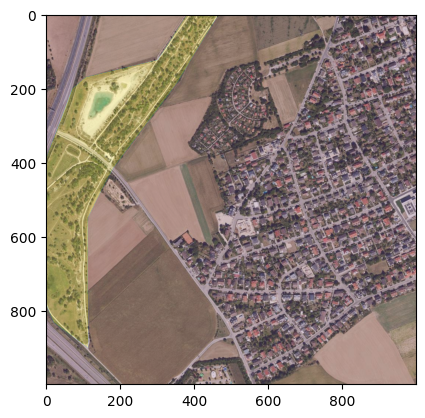

In [ ]:
mask99 = masks_files[99]
image_path = os.path.join(base_dir, mask99.split('.')[0] + '.jpg')

pls_work = np.load(os.path.join(masks_dir, mask99))
rand_area = np.array(Image.open(image_path))

plt.imshow(rand_area)
plt.imshow(pls_work, alpha=0.2);

In [ ]:
wuerzburg_image_urls = pd.read_csv("https://raw.githubusercontent.com/kleenman/tds_capstone/main/wuerzburg_test.csv",header=None)
wuerzburg_image_urls.head()

,0
0,https://download1.bayernwolke.de/a/dop40/data/...
1,https://download1.bayernwolke.de/a/dop40/data/...
2,https://download1.bayernwolke.de/a/dop40/data/...
3,https://download1.bayernwolke.de/a/dop40/data/...
4,https://download1.bayernwolke.de/a/dop40/data/...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/capstone project
!ls



Mounted at /content/drive
/content/drive/My Drive/capstone project
cache  Capstone


In [ ]:
import requests
from io import BytesIO
def download_and_rescale_image(url,filename, target_width=1000, target_height=1000):
    try:

        response = requests.get(url)
        response.raise_for_status()

        # Open the downloaded image using Pillow
        img = Image.open(BytesIO(response.content))

        # Resize the image to the target dimensions while preserving the aspect ratio
        img.thumbnail((target_width, target_height))

        # Save the resized image
        img.save(filename)
        print("Image downloaded and resized successfully!")
        return False
    except Exception as e:
        print("Error",e)
        return True



# Read the CSV file to get the image URLs
wuerzbug_urls = wuerzburg_image_urls[0].tolist()
# Folder path in Google Drive where you want to save the images
save_folder_path = '/content/drive/My Drive/capstone project/Capstone/Data/wuerzburg_data'

# Loop through the image URLs and download/rescale each image
for url in wuerzbug_urls:
    filename = url.split('/')[-1]  # This gets the last part of the URL (e.g., '32700_5330.tif')
    filename_without_extension = filename.split('.')[0]  # Removes the file extension (e.g., '32700_5330')
    full_save_path = f"{save_folder_path}/{filename_without_extension}_resized.jpg"

    # Download and resize the image
    #download_and_rescale_image(url, full_save_path)

In [ ]:
def create_mask(f):
  cords = f.split('_')
  x = cords[0]
  y = cords[1]
  X = int(x[2:]) * 1000
  Y = int(y) * 1000
  transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")
  south, west = transformer.transform(X, Y)
  north, east = transformer.transform(X + 1000, Y + 1000)
  geo_information = ox.features_from_bbox(north, south, east, west, tags={'leisure': 'park'})
  raster = np.zeros((1000,1000))
  if geo_information.empty:
    return raster
  for x_west in range(1000):
    for y_north in range(1000):
      x_west_coordinate = X+x_west
      y_north_coordinate = (Y+1000)-y_north
      small_north,small_west = transformer.transform(x_west_coordinate,y_north_coordinate)
      small_south,small_east = transformer.transform(x_west_coordinate+1,y_north_coordinate-1)
      # create a polygon for each square metre
      square_metre = Polygon([(small_west,small_north),(small_east,small_north),(small_east,small_south),(small_west,small_south)])
      #compare it to the geoinformation and set the value to 1 if it intersects
      if geo_information.intersects(square_metre).any():
        raster[y_north,x_west] = 1
  return raster

In [ ]:
base_dir = "/content/drive/MyDrive/capstone project/Capstone/Data/wuerzburg_data"
masks_dir = os.path.join(base_dir, "test_masks")
os.makedirs(masks_dir, exist_ok=True)


for f in os.listdir(base_dir):
  if f.endswith('.jpg'):
    parts = f.split('_')
    try:
      mask_filename = os.path.join(masks_dir, f'{parts[0]}_{parts[1]}.npy')
      if os.path.exists(mask_filename):
        continue
      mask = create_mask(f)
      np.save(mask_filename, mask)
    except Exception as e:
      mask = np.zeros((1000,1000))
      mask_filename = os.path.join(masks_dir, f'{parts[0]}_{parts[1]}.npy')
      np.save(mask_filename, mask)
      print(f'An error occured for file {f}: {e}')


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


An error occured for file 32562_5513_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for file 32572_5516_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for file 32565_5520_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for file 32568_5509_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for file 32563_5511_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for file 32568_5511_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for file 32568_5507_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for file 32565_5519_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occured for fil

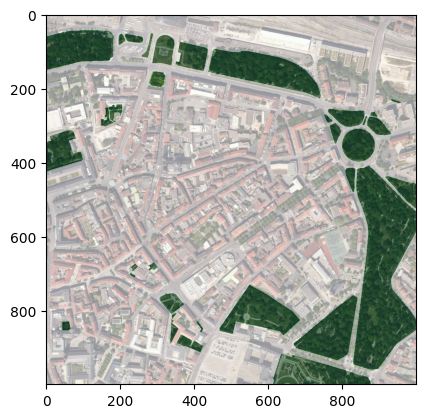

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image = np.array(Image.open("/content/drive/MyDrive/Capstone/Data/wuerzburg_data/32567_5516_resized.jpg"))
mask = np.load("/content/drive/MyDrive/Capstone/Data/wuerzburg_data/test_masks/32567_5516.npy")
plt.imshow(image)
plt.imshow(mask, cmap='Greens', alpha=0.5)  # Change color map to 'Greens'
plt.show()


In [ ]:
# Rename images in folders

for folder in os.listdir('/content/drive/MyDrive/Capstone/Data'):
  folder_path = os.path.join('/content/drive/MyDrive/Capstone/Data', folder)
  for f in os.listdir(folder_path):
    if f.endswith('.jpg'):
      f_path = os.path.join(folder_path, f)
      renamed = f.replace('_resized.jpg', '.jpg')
      new_path = os.path.join(folder_path, renamed)
      os.rename(f_path, new_path)

